# Prototyping Code for Flight Path Vizualizer

## 1. Loading OpenSky Data

This requires you to actively have credentials to access the Opensky DataBase, please check the [wiki page](https://github.com/Andrerg01/FlightPathAnalysis/wiki/Basic-OpenSky-Data-Usage) for more informaiton

### 1.1 Downloading Flights Information Data

This method allows you to download information about all flights withing a certain date range given an origin airport and a destination airport. 

Please refer to the [List of airports by IATA airport code](https://en.wikipedia.org/wiki/List_of_airports_by_IATA_airport_code:_A) for the precise IATA code of all airports.

The result is given as a pandas dataframe, containing 4 columns of interest (among some more)
 - firstseen: The UNIX UTC time the aircraft was first seen
 - lastseen: The UNIC UTC time the aircraft was last seen
 - icao24: The icao24 identification nunber of the airfract
 - callsign: The callsign of the aircraft for the current flight, providing information about the airline and flight number

In [64]:
import matplotlib.pyplot as plt 
import datetime
import yaml

# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
import sys
sys.path.append(root_path)
# Package for downloading opensky data 
from src.backend import opensky_query
# Utilities package
from src.backend import utils
# Package used to compress state vectors data
from src.backend import compressors


# This is here for, if you change something in any of the files, you don't have to restart the kernel
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# From here we load the config file
with open(f'{root_path}/config/config.yml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
        
# Checking if credentials file is specified, and if so, loading it.
credentials_file = config['base-configs']['opensky-credentials']
if not credentials_file:
    raise ValueError('No OpenSky credentials file specified in in config.yaml')

with open(f'{root_path}/{credentials_file}', 'r') as file:
    try:
        credentials = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

# Creates an instance of a logger class to log all that happens, optional (but encouraged) for querying.
logger = utils.Logger(config)
# Creates an instane of the Querier class used for querying the opensky database
opensky_querier = opensky_query.Querier(
    credentials['username'], 
    credentials['password'],
    config['data-gather']['flights']['hostname'], 
    config['data-gather']['flights']['port'], 
    logger = logger)

# Looking at all flights from Baton Rouge to Dallas from `Jan 1, 2022` to `Jan 7, 2022`
origin_airport = 'KBTR'
destination_airport = 'KDFW'
start_date = datetime.date(2022, 1, 1)
end_date = datetime.date(2022, 1, 7)

# This code will query the database and return the flights requested.
# As mentioned in the wiki, sometimes there are missing files for some days, which the code handles and adds as an exception before repeating the query
flights = opensky_querier.query_flight_data(
          origin_airport, 
          destination_airport, 
          start_date, 
          end_date)

flights

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023/10/10 18:12:12 : Querying data for flights from KBTR to KDFW between the dates 2021-12-31 HH:MM:SS and 2022-01-06 HH:MM:SS
2023/10/10 18:12:14 : Querying: SELECT firstseen, lastseen, callsign, icao24, estdepartureairport, estarrivalairport, day
    FROM flights_data4 
    WHERE estdepartureairport = 'KBTR' 
    AND estarrivalairport = 'KDFW'
    AND day >= 1640995200
    AND day <= 1641513600
    ORDER BY firstseen;
2023/10/10 18:14:21 : Bad day found, trying again.
2023/10/10 18:14:21 : Bad Days:
2023/10/10 18:14:21 :  - 2022-01-05 HH:MM:SS
2023/10/10 18:14:24 : Querying: SELECT firstseen, lastseen, callsign, icao24, estdepartureairport, estarrivalairport, day
    FROM flights_data4 
    WHERE estdepartureairport = 'KBTR' 
    AND estarrivalairport = 'KDFW'
    AND day >= 1640995200
    AND day <= 1641513600
    AND day != 1641427200
ORDER BY firstseen;


,firstseen,lastseen,callsign,icao24,estdepartureairport,estarrivalairport,day
0,1641047161,1641051233,SKW3125,a99b5f,KBTR,KDFW,1640995200
1,1641061714,1641065878,ENY3536,a8dbbd,KBTR,KDFW,1640995200
2,1641089450,1641093689,SKW3185,a972be,KBTR,KDFW,1641081600
3,1641125850,1641130088,SKW3125,a992cf,KBTR,KDFW,1641081600
4,1641147684,1641151763,ENY3536,a81db0,KBTR,KDFW,1641081600
5,1641160980,1641165650,N527RY,a6a47d,KBTR,KDFW,1641081600
6,1641176681,1641180605,SKW3185,a9b402,KBTR,KDFW,1641168000
7,1641211686,1641215658,SKW3041,a7f40f,KBTR,KDFW,1641168000
8,1641262310,1641266480,SKW3185,aa5d23,KBTR,KDFW,1641254400
9,1641310342,1641314338,SKW3256,a972be,KBTR,KDFW,1641254400


### 1.2 Downloading a Flight's State Vectors

This example code shows you how to download the flight's state vectors given one of the entries of the flights dataframe above.

It returns 5 columns of interest:
 - time: Recorded Unix UTC time of when the data was gathered
 - lat: Latitude of the aircraft at the given time
 - lon: Longitude of the aircraft at the given time
 - baroaltitude: Altitude of the aircraft according to the internal barometer at the given time
 - geoaltitude: Altitude of the aircraft according to the internal gps at the given time


2023/10/10 18:39:49 : Querying data for statevectors for ICAO24 a6a47d between the times 2022-01-02 and 2022-01-02
2023/10/10 18:39:51 : Querying: SELECT time, lat, lon, velocity, heading, baroaltitude, geoaltitude, onground, hour
    FROM state_vectors_data4
    WHERE icao24 = 'a6a47d' 
    AND (time >= 1641160980 AND time <= 1641165650)
    AND (hour > 1641157380 AND hour < 1641169250)
    ORDER BY time;


,time,lat,lon,velocity,heading,baroaltitude,geoaltitude,onground,hour
2,1.641161e+09,30.537570,-91.157190,68.403644,313.781125,60.96,106.68,false,1.641161e+09
4,1.641161e+09,30.538734,-91.158508,68.403644,313.781125,91.44,106.68,false,1.641161e+09
6,1.641161e+09,30.539525,-91.159442,70.935467,314.706178,114.30,137.16,false,1.641161e+09
7,1.641161e+09,30.539990,-91.159991,71.662991,314.709161,129.54,167.64,false,1.641161e+09
8,1.641161e+09,30.540177,-91.160211,71.662991,314.709161,137.16,175.26,false,1.641161e+09
...,...,...,...,...,...,...,...,...,...
4319,1.641166e+09,32.846558,-97.010101,68.422986,0.430787,228.60,335.28,false,1.641164e+09
4321,1.641166e+09,32.847725,-97.010062,67.394127,0.437364,220.98,335.28,false,1.641164e+09
4322,1.641166e+09,32.848330,-97.010062,67.394127,0.437364,220.98,335.28,false,1.641164e+09
4323,1.641166e+09,32.848846,-97.010046,66.365270,0.444144,213.36,335.28,false,1.641164e+09


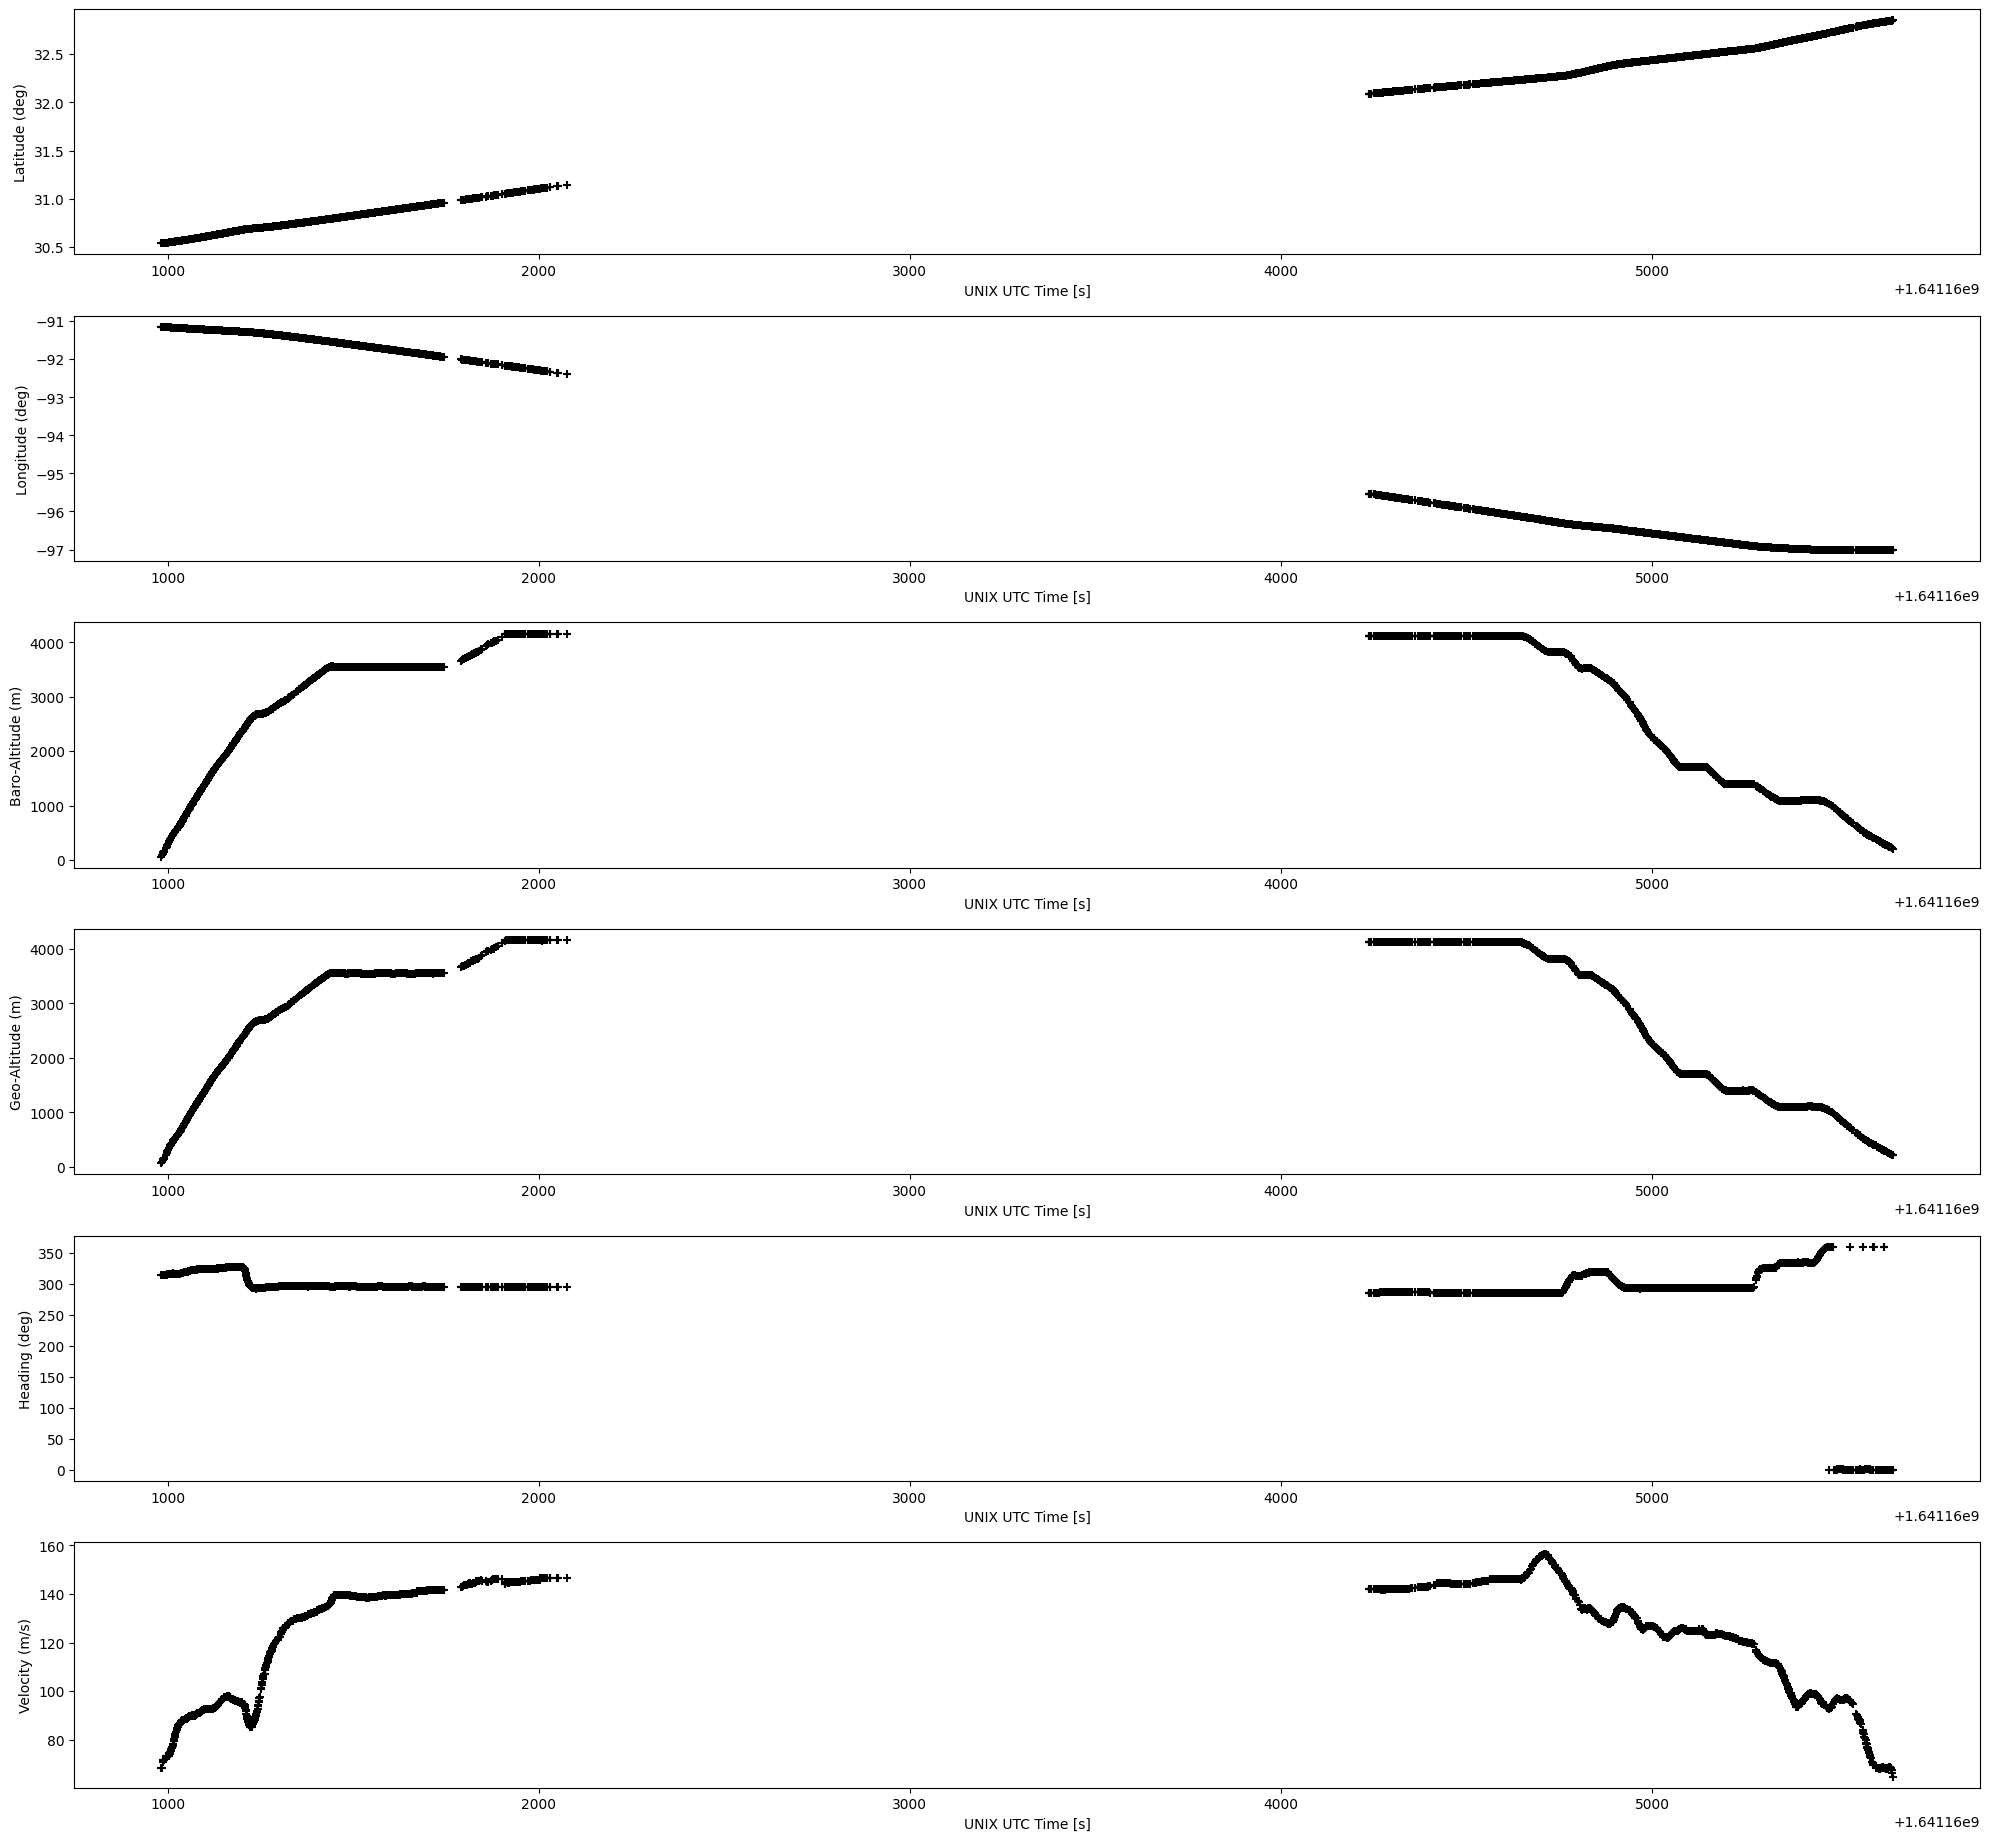

In [66]:
%matplotlib inline

# Let's choose a random flight out of the dataframe we got
flight = flights.sample(1).iloc[0]

# Similarly to querying flight data, there are 'bad hours' which can happen
state_vectors = opensky_querier.query_state_vectors(
                flight['icao24'],
                flight['firstseen'],
                flight['lastseen'])

# Checks if no sneaky strings make it into the rows
cols_to_check = ['time', 'lat', 'lon', 'velocity', 'heading', 'baroaltitude', 'geoaltitude', 'hour']
for col in cols_to_check:
    state_vectors[col] = state_vectors[col].apply(lambda x: np.nan if isinstance(x, str) else x)
state_vectors.dropna(inplace=True)

# This drops identical columns. If OpenSky does not have the data for some time, it just fills it with the previous (or sometimes future) datapoint, we don't want that, so we check to see if a row's lat and lon is repeated (that is, if the aircraft did not move), then we clean it.
cols_to_check = ['lat', 'lon']
state_vectors = state_vectors.drop_duplicates(subset=cols_to_check, keep='first')

fig, ax = plt.subplots(6, figsize = [20, 30/1.62])
ax[0].scatter(state_vectors['time'], state_vectors['lat'], color = 'k', marker = '+')
ax[0].set_xlabel('UNIX UTC Time [s]')
ax[0].set_ylabel('Latitude (deg)')

ax[1].scatter(state_vectors['time'], state_vectors['lon'], color = 'k', marker = '+')
ax[1].set_xlabel('UNIX UTC Time [s]')
ax[1].set_ylabel('Longitude (deg)')

ax[2].scatter(state_vectors['time'], state_vectors['baroaltitude'], color = 'k', marker = '+')
ax[2].set_xlabel('UNIX UTC Time [s]')
ax[2].set_ylabel('Baro-Altitude (m)')

ax[3].scatter(state_vectors['time'], state_vectors['baroaltitude'], color = 'k', marker = '+')
ax[3].set_xlabel('UNIX UTC Time [s]')
ax[3].set_ylabel('Geo-Altitude (m)')

ax[4].scatter(state_vectors['time'], state_vectors['heading'], color = 'k', marker = '+')
ax[4].set_xlabel('UNIX UTC Time [s]')
ax[4].set_ylabel('Heading (deg)')

ax[5].scatter(state_vectors['time'], state_vectors['velocity'], color = 'k', marker = '+')
ax[5].set_xlabel('UNIX UTC Time [s]')
ax[5].set_ylabel('Velocity (m/s)')

fig.tight_layout()

state_vectors.to_csv(f'{root_path}/data/example/flight/state_vectors_example.csv')

state_vectors

## 2. Compressing and Decompressing State Vector Data

This section covers the algorithm used to compress and decompress the state vector data. Beware that this is a lossy process. It's meant to capture the shape of each of the variables in the statevector, which minimizing the amount of data necessary for storage.

The first step is to normalize all the data between 0 and 1 but re-ranging it: $x -> (x - xmin)/(xmax - xmin)$.

Each curve of interest for each flight will be converted to a spline. The precision $s$ (s = 0 -> maximum precision) will be determined such that the spline will be the one that results with the smallest total length of coefficients and knots while minimizing s, and still passes the pearson correlation threshold against the original data.

Note: a small s will result in a better precision, but also more coefficients.
Note on the algorithm: 
 - First find the largest `s` that still passes the threshold
 - Thne find the smallest `s` that does not present a higher complexity (len(knots) + len(coeffs))
 
The information of the coefficients, knots, minimum and maxium of all variables is stored and used to reconstruct the original spline and data.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Compression Factor: 4.286004594451317
could not determine a constructor for the tag 'tag:yaml.org,2002:python/object/apply:numpy.core.multiarray.scalar'
  in "..//data/example/flight/example_splines.yml", line 47, column 9


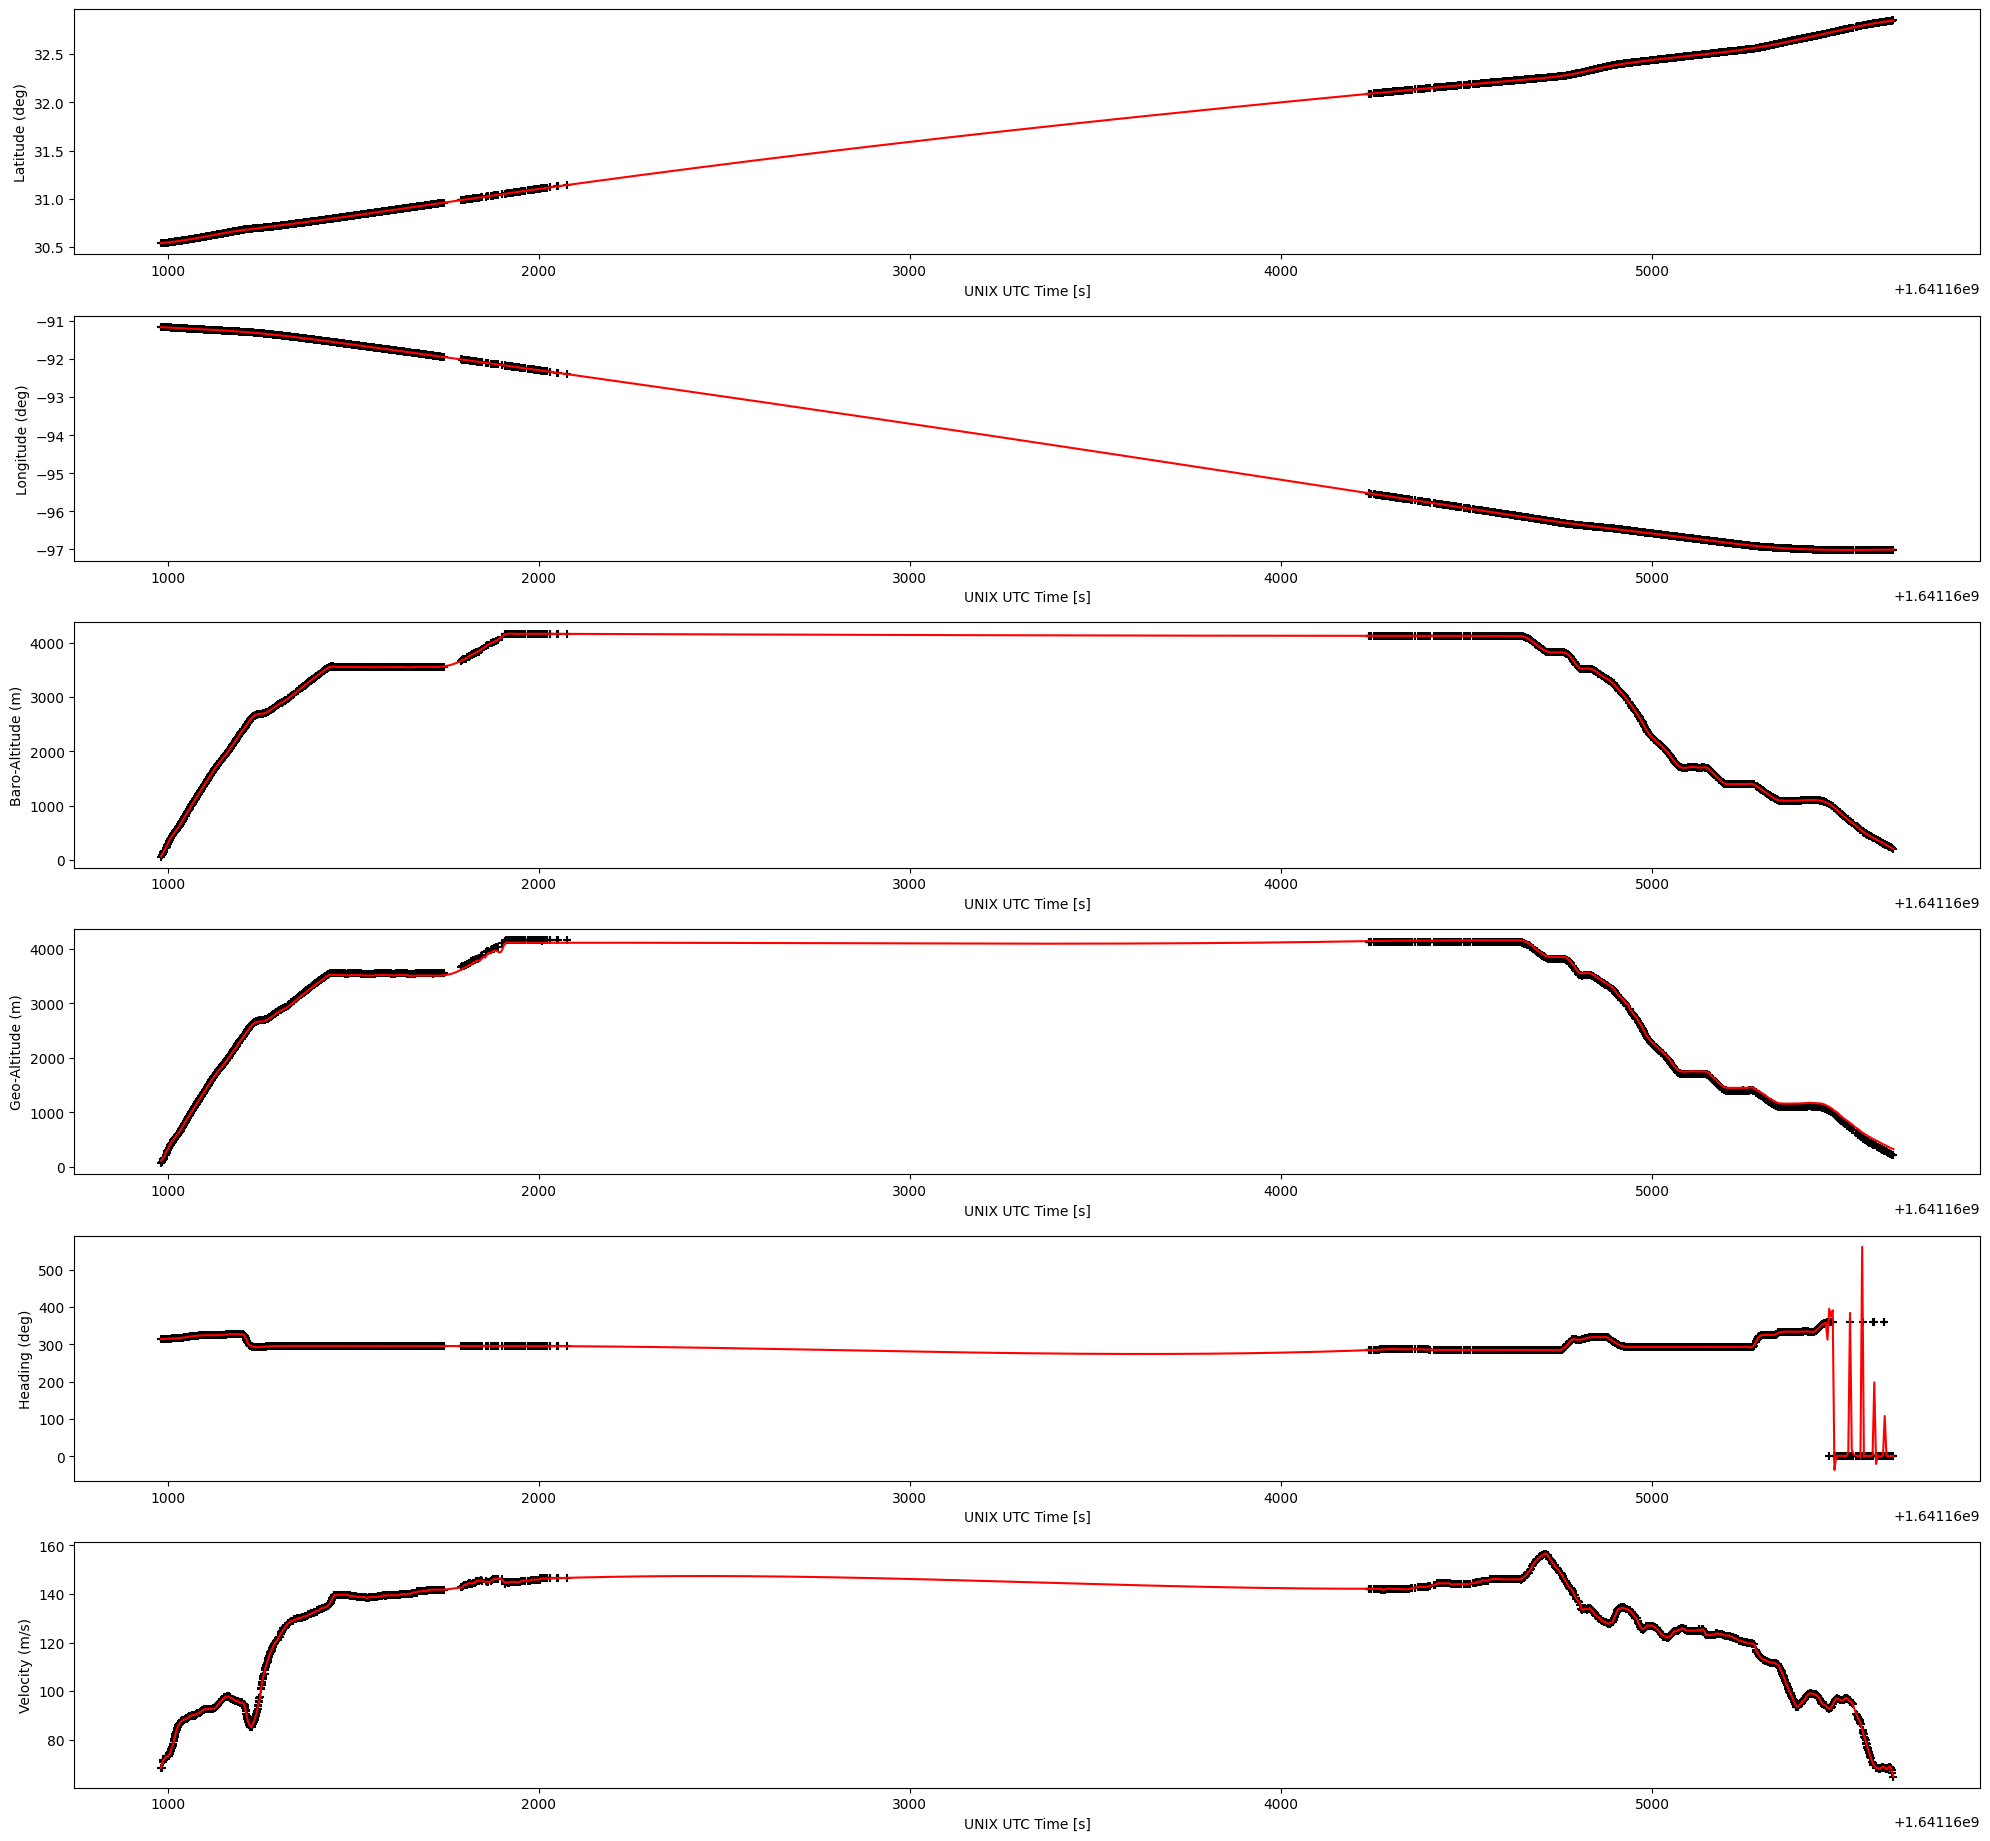

In [8]:
import matplotlib.pyplot as plt 
import datetime
import yaml
import pandas as pd
import numpy as np

# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
import sys
sys.path.append(root_path)
# Package for downloading opensky data 
from src.backend import opensky_query
# Utilities package
from src.backend import utils
# Package used to compress state vectors data
from src.backend import compressors

# This is here for, if you change something in any of the files, you don't have to restart the kernel
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# From here we load the config file
with open(f'{root_path}/config/config.yml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

# Loading state vectos from csv, not needed if you just ran the steps above
state_vectors = pd.read_csv(f'{root_path}/data/example/flight/state_vectors_example.csv', index_col=0)

# Creates an instance of the SplineCompressor class.
compressor = compressors.SplineCompressor(config)

# List of columns of state_vectors to be compressed.
columns = ['lat', 'lon', 'baroaltitude', 'geoaltitude', 'heading', 'velocity']
# This method encodes the information from the columns into a dictionary, which can be used to recreate the data upon request.
metadata = compressor.encode_from_dataframe(state_vectors, 'time', columns)
# Computes the compression factor achieved as x_old/x_new.
compression_factor = compressor.compute_compression_factor(state_vectors['time'].values, state_vectors[columns].values, metadata)
print(f"Compression Factor: {compression_factor}")
# Turns dictionary data into the yaml format
yaml_data = yaml.dump(metadata, default_flow_style=None)
# Saves it to a yaml file
with open(f"{root_path}/data/example/flight/example_splines.yml", 'w') as f:
    f.write(yaml_data)
    
# We can now retrive the yaml file and reconstruct it
# From here we load the config file
with open(f"{root_path}/data/example/flight/example_splines.yml", 'r') as file:
    try:
        metadata = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

# This can then be saved to a yml file, it can be recovered from the method below (for now it just supports one column at a time)
# It returns a function for which an input x can be given and it will output the corresponding reconstructed data
spline_lat = compressor.decode_spline_single_column(metadata, 'lat')
spline_lon = compressor.decode_spline_single_column(metadata, 'lon')
spline_balt = compressor.decode_spline_single_column(metadata, 'baroaltitude')
spline_galt = compressor.decode_spline_single_column(metadata, 'geoaltitude')
spline_head = compressor.decode_spline_single_column(metadata, 'heading')
spline_vel = compressor.decode_spline_single_column(metadata, 'velocity')

fig, ax = plt.subplots(6, figsize = [20, 30/1.62])
x = np.linspace(metadata['lat']['xmin'], metadata['lat']['xmax'], num = 1000)

y_lat = spline_lat(x)
y_lon = spline_lon(x)
y_balt = spline_balt(x)
y_galt = spline_galt(x)
y_head = spline_head(x)
y_vel = spline_vel(x)

ax[0].scatter(state_vectors['time'], state_vectors['lat'], color = 'k', marker = '+')
ax[0].plot(x, y_lat, color = 'red')
ax[0].set_xlabel('UNIX UTC Time [s]')
ax[0].set_ylabel('Latitude (deg)')

ax[1].scatter(state_vectors['time'], state_vectors['lon'], color = 'k', marker = '+')
ax[1].plot(x, y_lon, color = 'red')
ax[1].set_xlabel('UNIX UTC Time [s]')
ax[1].set_ylabel('Longitude (deg)')

ax[2].scatter(state_vectors['time'], state_vectors['baroaltitude'], color = 'k', marker = '+')
ax[2].plot(x, y_balt, color = 'red')
ax[2].set_xlabel('UNIX UTC Time [s]')
ax[2].set_ylabel('Baro-Altitude (m)')

ax[3].scatter(state_vectors['time'], state_vectors['baroaltitude'], color = 'k', marker = '+')
ax[3].plot(x, y_galt, color = 'red')
ax[3].set_xlabel('UNIX UTC Time [s]')
ax[3].set_ylabel('Geo-Altitude (m)')

ax[4].scatter(state_vectors['time'], state_vectors['heading'], color = 'k', marker = '+')
ax[4].plot(x, y_head, color = 'red')
ax[4].set_xlabel('UNIX UTC Time [s]')
ax[4].set_ylabel('Heading (deg)')

ax[5].scatter(state_vectors['time'], state_vectors['velocity'], color = 'k', marker = '+')
ax[5].plot(x, y_vel, color = 'red')
ax[5].set_xlabel('UNIX UTC Time [s]')
ax[5].set_ylabel('Velocity (m/s)')

fig.tight_layout()

In [5]:
metadata

{'x_variable': 'time',
 'max_error': 0.001,
 's_min_precision': 0.001,
 'y_variables': ['lat',
  'lon',
  'baroaltitude',
  'geoaltitude',
  'heading',
  'velocity'],
 'lat': {'xmin': 1641160982.0,
  'xmax': 1641165650.0,
  'ymin': 30.53756972490731,
  'ymax': 32.85067749023438,
  'coefficients': [0.0,
   0.0005000823539813003,
   0.0005747991706815205,
   0.0010875303768629857,
   0.0010978410542285212,
   0.001283242536708342,
   0.0020645718770406934,
   0.0025703844228285784,
   0.0027541721694532,
   0.0032691816644515267,
   0.0034814930491816037,
   0.003575740618438291,
   0.004153101140812414,
   0.0043799957894193366,
   0.004787608783353784,
   0.004725642086762649,
   0.005117332061881647,
   0.005234646752973459,
   0.005565261750711974,
   0.005793912858030009,
   0.006197809079411228,
   0.006143373640485614,
   0.00670421883099988,
   0.0066525918509217396,
   0.007016731650819882,
   0.007181581265166331,
   0.007486319944245345,
   0.007710535722900023,
   0.007678220

# 3. Plotting and Finding Flight Paths

This part is still ongoing, I have not done serious coding for the steps below, only the steps above

## 1.1 Plotting flight path from raw CSV

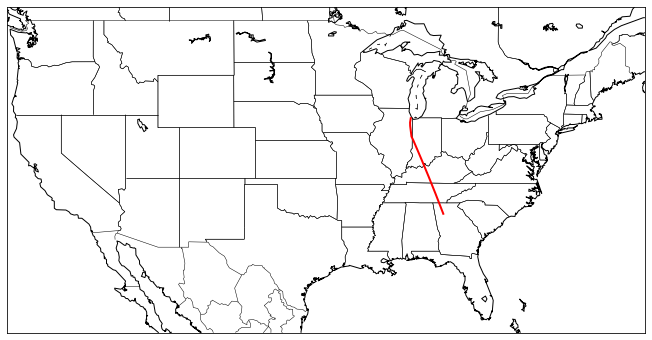

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Path to the csv containing the state vectors for the flight in question
csv_file = 'data/raw_data/Example_Flight_Path.csv'
# ID of flight
# icao24 = 'ad7bdf'
icao24 = 'a2fb32'
# Loading the csv into a dataframe
flight_path = pd.read_csv(csv_file).dropna()
flight_path = flight_path[flight_path['icao24'] == icao24]

# Loading latitutes and longitudes
lats = flight_path['lat']
lons = flight_path['lon']

fig, ax = plt.subplots(figsize=(12, 6))

# Adjust the latitude and longitude bounds to focus on the US
m = Basemap(projection='mill',llcrnrlat=24,urcrnrlat=50,\
            llcrnrlon=-125,urcrnrlon=-66,resolution='l', ax=ax)  # 'l' for low resolution

m.drawcoastlines()
m.drawcountries()
m.drawstates()  # To draw state boundaries

x, y = m(lons, lats)

# Plot the transformed coordinates on the map
m.plot(x, y, 'r-', markersize=5, linewidth=2)

plt.show()


## 1.2 Compressing data into small file for interpolation

Compression: 99.94


/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_16081/3838428172.py:107: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'blue', alpha = 0.5, label = 'original')
/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_16081/3838428172.py:111: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'red', alpha = 0.5, label = 'reconstructed')


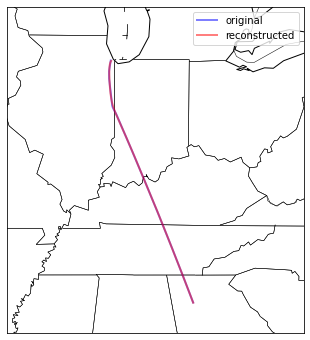

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from simplification.cutil import simplify_coords
from scipy.interpolate import UnivariateSpline
import pickle as pkl
import os

# Path to the csv containing the state vectors for the flight in question
csv_file = 'data/raw_data/Example_Flight_Path.csv'
# ID of flight
# icao24 = 'ad7bdf'
icao24 = 'a2fb32'
# Path to spline file
spline_file = 'data/raw_data/Example_Flight_Path.pkl'
# Loading the csv into a dataframe and cleaning it up
flight_path = pd.read_csv(csv_file).dropna().drop(['callsign', 'spi', 'squawk', 'lastposupdate', 'lastcontact'], axis = 'columns')
flight_path = flight_path[flight_path['icao24'] == icao24]
flight_path = flight_path[flight_path['onground'] == False]
flight_path = flight_path.drop(['onground', 'icao24'], axis = 'columns')
flight_path['altitude'] = 0.5*(flight_path['geoaltitude'] + flight_path['baroaltitude'])
flight_path = flight_path.drop(['geoaltitude', 'baroaltitude'], axis = 'columns')

def spline_maker(flight_path, icao24, filename):
    """
    Create a spline representation of a flight path and save it to a file.
    
    Parameters:
        flight_path (DataFrame): The flight path data.
        icao24 (str): An ID referring to the flight.
        filename (str): Name of the file to save the spline.
        
    Returns:
        None
    """
    x = flight_path['time'].values
    
    splines = {}
    for column in ['lat', 'lon', 'velocity', 'altitude']:
        y = flight_path[column].values
        spline = UnivariateSpline(x, y, s=0.01)
        splines[column] = spline

    # Save the splines, icao24, start time, and end time to a file
    data = {
        'icao24': icao24,
        'start_time': x[0],
        'end_time': x[-1],
        'splines': splines
    }
    with open(spline_file, 'wb') as f:
        pkl.dump(data, f)
    return data


def spline_reader(data, ts):
    """
    Read a spline representation from a file and rebuild the flight path using given time intervals.
    
    Parameters:
        filename (str): Name of the file containing the spline representation.
        time_intervals (array-like): Time intervals at which to rebuild the path.
        
    Returns:
        reconstructed_path (DataFrame): The reconstructed flight path data.
    """
    
    splines = data['splines']
    reconstructed_data = {'time': ts}
    
    for column, spline in splines.items():
        reconstructed_data[column] = spline(ts)
        
    reconstructed_path = pd.DataFrame(reconstructed_data)
    
    return reconstructed_path

# Example usage:
data = spline_maker(flight_path, 'a2fb32', 'spline_representation.pkl')
ts = np.linspace(flight_path['time'].values[0], flight_path['time'].values[-1], num=1000)  # You can adjust start_time, end_time, and num as required
reconstructed_path = spline_reader('spline_representation.pkl', ts)

size_original = os.path.getsize(csv_file)
size_spline = os.path.getsize(spline_file)

print("Compression: " + str(round(100 - 100*size_spline/size_original, 2)))

lons_original = flight_path['lon']
lons_reconstructed = reconstructed_path['lon']
lats_original = flight_path['lat']
lats_reconstructed = reconstructed_path['lat']

fig, ax = plt.subplots(figsize=(12, 6))

# Adjust the latitude and longitude bounds to focus on the US
m = Basemap(projection='mill',llcrnrlat=24,urcrnrlat=50,\
            llcrnrlon=-125,urcrnrlon=-66,resolution='l', ax=ax)  # 'l' for low resolution

m.drawcoastlines()
m.drawcountries()
m.drawstates()  # To draw state boundaries

x, y = m(lons_original, lats_original)

# Plot the transformed coordinates on the map
m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'blue', alpha = 0.5, label = 'original')

x, y = m(lons_reconstructed, lats_reconstructed)

m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'red', alpha = 0.5, label = 'reconstructed')

rangeX = max(x) - min(x)
rangeY = max(y) - min(y)
ax.set_xlim([0.9*min(x), 1.1*max(x)])
ax.set_ylim([0.9*min(y), 1.1*max(y)])
ax.legend()

plt.show()

## 1.3 Computing shortest path from $x_0$, $y_0$, to $x_f$, $y_f$

/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_16081/3067399314.py:95: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'blue', alpha = 0.5, label = 'original')
/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_16081/3067399314.py:99: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'red', alpha = 0.5, label = 'reconstructed')
/var/folders/5c/4dc4m3p13_gd8160xmlxf97c0000gn/T/ipykernel_16081/3067399314.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'green', alpha = 0.5, lab

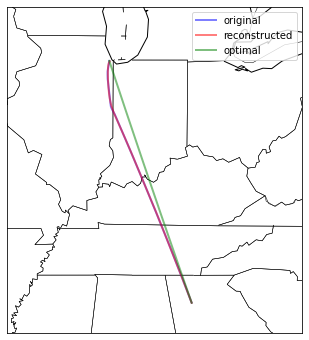

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from simplification.cutil import simplify_coords
from scipy.interpolate import UnivariateSpline
import pickle as pkl
import os

# Path to the csv containing the state vectors for the flight in question
csv_file = 'data/raw_data/Example_Flight_Path.csv'
# ID of flight
# icao24 = 'ad7bdf'
icao24 = 'a2fb32'
# Path to spline file
spline_file = 'data/raw_data/Example_Flight_Path.pkl'
# Loading the csv into a dataframe and cleaning it up
flight_path = pd.read_csv(csv_file).dropna().drop(['callsign', 'spi', 'squawk', 'lastposupdate', 'lastcontact'], axis = 'columns')
flight_path = flight_path[flight_path['icao24'] == icao24]
flight_path = flight_path[flight_path['onground'] == False]
flight_path = flight_path.drop(['onground', 'icao24'], axis = 'columns')
flight_path['altitude'] = 0.5*(flight_path['geoaltitude'] + flight_path['baroaltitude'])
flight_path = flight_path.drop(['geoaltitude', 'baroaltitude'], axis = 'columns')

def spline_reader(data, ts):
    """
    Read a spline representation from a file and rebuild the flight path using given time intervals.
    
    Parameters:
        filename (str): Name of the file containing the spline representation.
        time_intervals (array-like): Time intervals at which to rebuild the path.
        
    Returns:
        reconstructed_path (DataFrame): The reconstructed flight path data.
    """
    
    splines = data['splines']
    reconstructed_data = {'time': ts}
    
    for column, spline in splines.items():
        reconstructed_data[column] = spline(ts)
        
    reconstructed_path = pd.DataFrame(reconstructed_data)
    
    return reconstructed_path

precision = 1000
lat_0 = flight_path.iloc[0]['lat']
lon_0 = flight_path.iloc[0]['lon']

lat_f = flight_path.iloc[-1]['lat']
lon_f = flight_path.iloc[-1]['lon']

tht_0 = (90 - lat_0)/180*np.pi
phi_0 = (lon_0)/180*np.pi

tht_f = (90 - lat_f)/180*np.pi
phi_f = (lon_f)/180*np.pi

dphi = phi_f - phi_0
if abs(dphi) > np.pi:
    dphi = -(2*np.pi - abs(dphi))

phis_opt = np.linspace(phi_0, phi_0 + dphi, num = precision)
# phis_opt[phis_opt < 0] = phis_opt[phis_opt < 0] + 2*np.pi

thts_opt = np.linspace(tht_0, tht_f, num = precision)

lons_optimal = phis_opt/np.pi*180
lats_optimal = 90 - thts_opt/np.pi*180


with open(spline_file, 'rb') as f:
    data = pkl.load(f)
reconstructed_path = spline_reader(data, ts)

lons_original = flight_path['lon']
lons_reconstructed = reconstructed_path['lon']
lats_original = flight_path['lat']
lats_reconstructed = reconstructed_path['lat']

fig, ax = plt.subplots(figsize=(12, 6))

# Adjust the latitude and longitude bounds to focus on the US
m = Basemap(projection='mill',llcrnrlat=24,urcrnrlat=50,\
            llcrnrlon=-125,urcrnrlon=-66,resolution='l', ax=ax)  # 'l' for low resolution

m.drawcoastlines()
m.drawcountries()
m.drawstates()  # To draw state boundaries

x, y = m(lons_original, lats_original)

# Plot the transformed coordinates on the map
m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'blue', alpha = 0.5, label = 'original')

x, y = m(lons_reconstructed, lats_reconstructed)

m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'red', alpha = 0.5, label = 'reconstructed')

x, y = m(lons_optimal, lats_optimal)

m.plot(x, y, 'r-', markersize=5, linewidth=2, color = 'green', alpha = 0.5, label = 'optimal')

rangeX = max(x) - min(x)
rangeY = max(y) - min(y)
ax.set_xlim([0.9*min(x), 1.1*max(x)])
ax.set_ylim([0.9*min(y), 1.1*max(y)])
ax.legend()

path_divergence = 

plt.show()

## 1.4 Computing "Ideal path" from $x_0$, $y_0$, to $x_f$, $y_f$ considering the Coriollis effect
This is the code to compute the ideal path between two points in a rotating sphere given the coriolis effect.
This does not take altitude or velocity into consideration.

The coriolis acceleration can be described as:
$$a_c = -2\vec{\omega}\times\dot{\vec{r}}$$
Where $\vec{\omega}$ is the angular rotation vector of the sphere (Earth),
and $\vec{r}$ is the position vector of the aircraft with the origin at the center of the earth, and the dot notations indicates a time derivative.

We'll work under the following assumptions and conventions:
 - The aricraft does not leave the surface of the Earth (ignoring altitude).
 - The Earth is a perfect sphere
 - $r$ is the radial distance $r = R_e = constant$
 - $\theta$ is the polar angle $[0, \pi]$
 - $\phi$ is the azimuthal angle $[0, 2\pi)$
 - The rotation of the earth is aligned with $\hat{z}$
 - The airfract applies constant thrust thorugh the journey

Thus, at any position $\vec{r}$, we know the forces acting on the aircraft should be:

$$\vec{F} = m \ddot{\vec{r}} = F_T\hat{\dot{r}} -2m\vec{\omega}\times\dot{\vec{r}}$$

Where $F_T$ is the constant thrust force in Newtons applied by the plane, $\hat{\dot{r}}$ is the heading of the plane, $\ddot{\vec{r}}$ is the acceleration of the plane, and $m$ is the mass of the plane.

We can simplify this with the new quantity $T_W$ as the Thrust-to-Weight ratio, defined as $T_W = \frac{F_T}{m g}$

$$\ddot{\vec{r}} = gT_w\hat{\dot{r}} - 2\vec{\omega}\times\dot{\vec{r}}$$

Now it's a matter of extremizing $r(t)$ such that it minimizes some quantity btween the two positions under the constraint

$$|\vec{r}| = R_e$$

There are two paths to consider:
 - Path that minimizes the total distance
 - Path that minimizes the total travel time (not the same, because of coriolis force)
Sinze we're considering constant thrust, the path that minimized time is also the same that minimizes fuel expense.

Let's focus on the path that minimizes the time.

$$T = \int_{\vec{r}_0}^{\vec{r}_f} dt$$

(cont...)

# 2. Accessing data

## 2.1 Accessing Opensky-Network database through python ssh+querying

In [14]:
import paramiko
import pandas as pd
import yaml
import sys
import datetime
sys.path.append('..')
from src.backend import opensky_query
from src.backend import utils

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# ssh -p 2230 -l andrerg01 data.opensky-network.org

with open('../config/opensky_login.yml', 'r') as file:
    try:
        credentials = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
        
with open('../config/config.yml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
        
# SSH configurations

logger = utils.Logger(config)

Querier = opensky_query.Querier(credentials['username'], 
                                credentials['password'], 
                                config['data-gather']['flights']['hostname'], 
                                config['data-gather']['flights']['port'], 
                                logger = logger)
del credentials

start_time = datetime.datetime(2023, 6, 1)
end_time = start_time + datetime.timedelta(days = 3)

results_flights = Querier.query_flight_data('KBTR', 'KDFW', start_time, end_time)

# results_flights['flight_id'] = [f"{row['icao24']}_{row['firstseen']}_{row['lastseen']}_{row['estdepartureairport']}_{row['estarrivalairport']}" for i, row in results_flights.iterrows()]

results_flights

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023/10/10 13:00:34 : Querying data for flights from KBTR to KDFW between the dates 2023-05-31 HH:MM:SS and 2023-06-03 HH:MM:SS
2023/10/10 13:00:37 : Querying: SELECT firstseen, lastseen, callsign, icao24, estdepartureairport, estarrivalairport, day
    FROM flights_data4 
    WHERE estdepartureairport = 'KBTR' 
    AND estarrivalairport = 'KDFW'
    AND day >= 1685577600
    AND day <= 1685836800
    ORDER BY firstseen;



KeyboardInterrupt



In [14]:
a = 'test\nv'
a.encode().decode()

'test\nv'

In [20]:
string = """
WARNINGS: Disk I/O error: Error reading from HDFS file: hdfs://nameservice1/user/opensky/tables_v4/flights/day=1685836800/part-r-00169-ddd97750-7950-42c9-b236-4a9c7e9106ae.snappy.parquet
Error(255): Unknown error 255
Root cause: BlockMissingException: Could not obtain block: BP-2086186090-192.168.6.170-1416410368441:blk_1716518662_875005380 file=/user/opensky/tables_v4/flights/day=1685836800/part-r-00169-ddd97750-7950-42c9-b236-4a9c7e9106ae.snappy.parquet"""
string.split('\n')[3]

'Root cause: BlockMissingException: Could not obtain block: BP-2086186090-192.168.6.170-1416410368441:blk_1716518662_875005380 file=/user/opensky/tables_v4/flights/day=1685836800/part-r-00169-ddd97750-7950-42c9-b236-4a9c7e9106ae.snappy.parquet'

In [410]:
flight = results_flights.iloc[5]

icao24 = flight['icao24']
start_time = int(flight['firstseen'])
end_time = int(flight['lastseen'])

results_vectors = Querier.query_state_vectors(icao24, start_time, end_time)

results_vectors = results_vectors[results_vectors['onground'].apply(lambda x: x == 'false')]
results_vectors = results_vectors[~(results_vectors == 'NULL').any(axis=1)]
results_vectors.drop_duplicates(inplace = True)
results_vectors

2023/10/08 20:27:49 : Querying data for statevectors for ICAO24 aa11dc between the times 2023-06-02 and 2023-06-02
2023/10/08 20:27:51 : Querying: SELECT time, lat, lon, velocity, heading, baroaltitude, geoaltitude, onground, hour
    FROM state_vectors_data4
    WHERE icao24 = 'aa11dc' 
    AND (time >= 1685753450 AND time <= 1685757323)
    AND (hour > 1685749850 AND hour < 1685760923)
    ORDER BY time;


,time,lat,lon,velocity,heading,baroaltitude,geoaltitude,onground,hour
0,1685753450,NULL,NULL,79.314519,313.948819,NULL,NULL,false,1685750400
1,1685753451,30.540527,-91.160727,79.314519,313.948819,144.78,NULL,false,1685750400
2,1685753452,30.541201,-91.161475,79.685698,313.692104,160.02,106.68,false,1685750400
3,1685753453,30.54148,-91.161859,79.685698,313.692104,167.64,114.3,false,1685750400
4,1685753454,30.54148,-91.161859,79.685698,313.692104,167.64,114.3,false,1685750400
...,...,...,...,...,...,...,...,...,...
3869,1685757319,32.93692,-97.025922,59.677721,180.493917,342.9,289.56,false,1685754000
3870,1685757320,32.93692,-97.025922,59.677721,180.493917,342.9,289.56,false,1685754000
3871,1685757321,32.934731,-97.025925,59.677721,180.493917,335.28,289.56,false,1685754000
3872,1685757322,32.934731,-97.025925,59.675504,180,335.28,281.94,false,1685754000


# 3. Data Compression Algorithm

Each curve of interest for each flight will be converted to a spline. The precision "s" will be determined such that the spline will be the one that results with the smallest total length of coefficients while minimizing s <> knots, and still passes the pearson correlation threshold agains the original data.

Note: a small s will result in a better precision, but also more coefficients.
Note on the algorithm: 
 - First find the largest `s` that still passes the threshold
 - Thne find the smallest `s` that does not present a higher complexity (len(knots) + len(coeffs))

flight_id: a99686_1685667930_1685671930
lon:
  coefficients: [0.9935599667440038, 0.9939013112839666, 0.9938866153806556, 0.9939391356008382,
    0.9937782421541186, 0.9943824257758593, 0.994255912410242, 0.9941577822509728,
    0.9946768162536648, 0.994667619529075, 0.9948536537256949, 0.9949759045481809,
    0.9948916189960242, 0.9951065103821646, 0.9951665820159672, 0.9953796853955718,
    0.9954849096755074, 0.9955606850677025, 0.9957638584486597, 0.9958778114840988,
    0.9959427973707741, 0.9959587315475209, 0.9962143798981723, 0.9963224133744082,
    0.9964426836722814, 0.9966332305223821, 0.9964747442334387, 0.9969181425391125,
    0.9968678184555307, 0.9971170997937049, 0.9972076632891648, 0.9973605020061718,
    0.9974786477881961, 0.9976328874608636, 0.9977549738725452, 0.9978767625902272,
    0.9979292508313556, 0.9980987201248633, 0.9982255455940797, 0.9983622867917468,
    0.9984681580496907, 0.9986078800455519, 0.9987074948412393, 0.9988790895541696,
    0.99896666623479

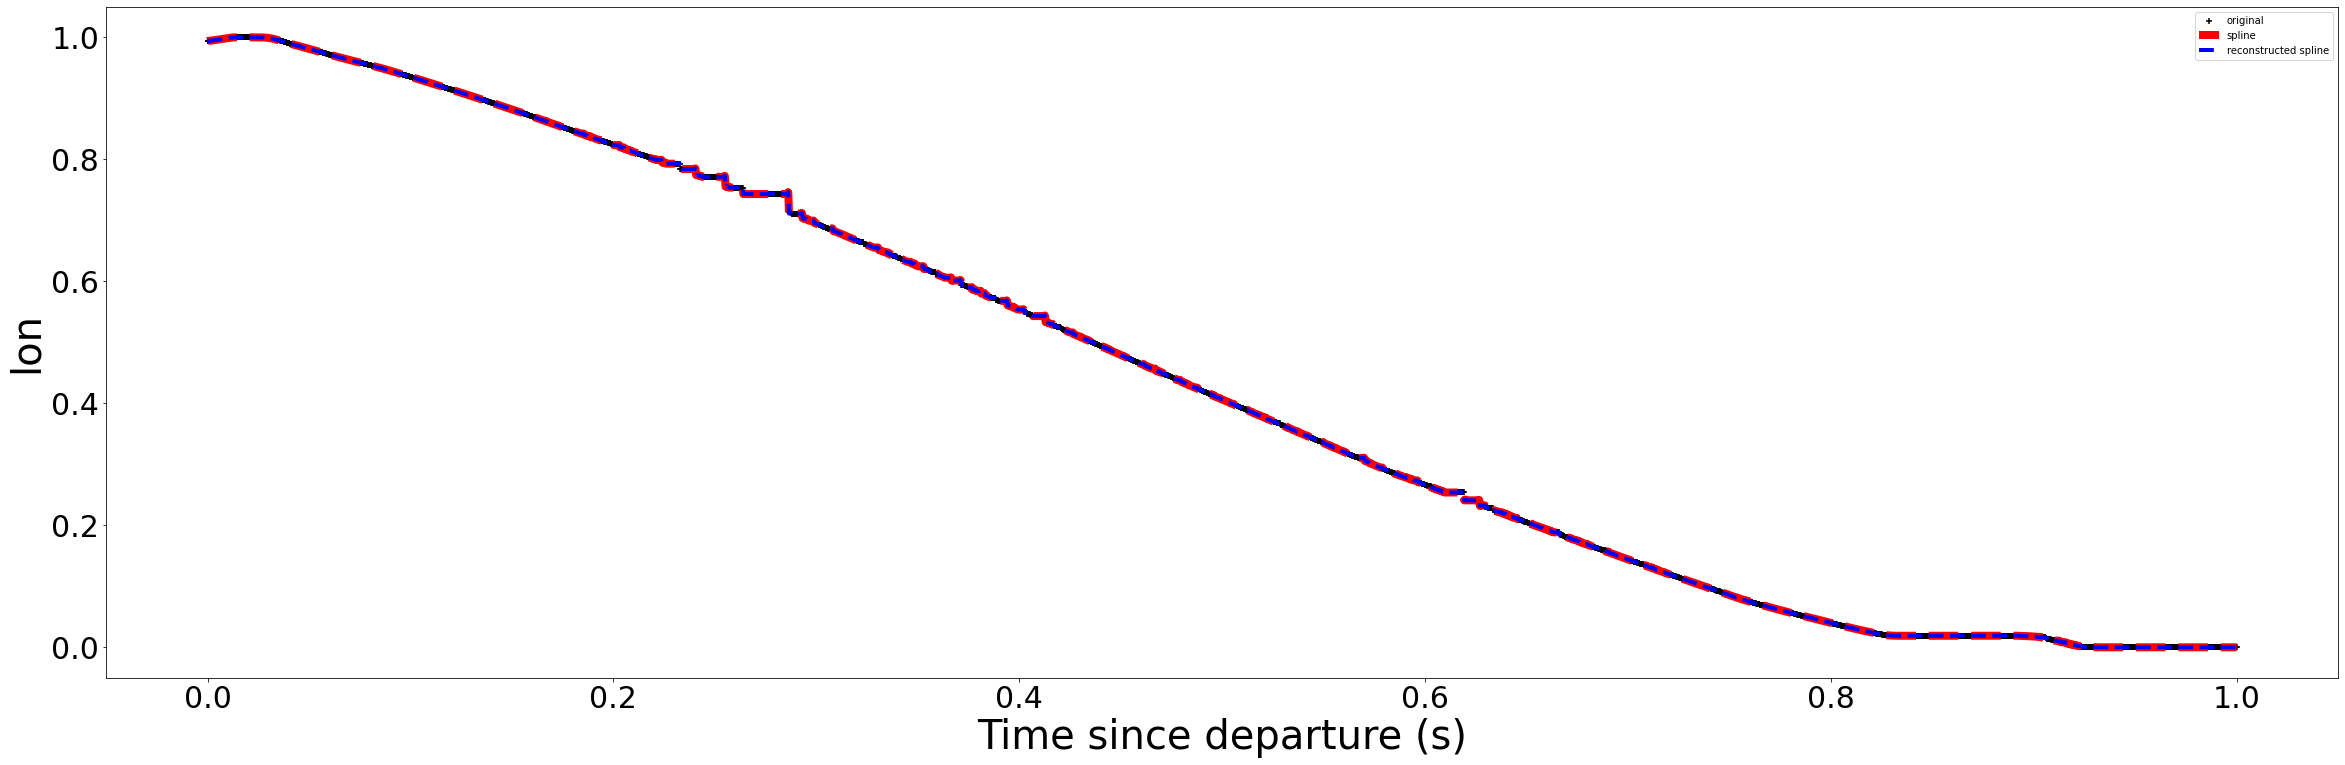

In [375]:
# Maybe normalize data first, save metadata values for reconstruction

import matplotlib.pyplot as plt
sys.path.append('../src/backend/')
import utils
import compressors
from scipy.interpolate import UnivariateSpline
import numpy as np

with open('../config.yml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

x_variable = 'time'
y_variable = 'lon'
original_xs = results_vectors[x_variable].values
original_ys = results_vectors[y_variable].values
xs = (original_xs - min(original_xs))/(max(original_xs) - min(original_xs))
ys = (original_ys - min(original_ys))/(max(original_ys) - min(original_ys))

compressor = compressors.SplineCompressor(config)

best_s = compressor.best_spline_s(xs, ys)

spline = UnivariateSpline(xs, ys, s = best_s)

spline_xs = np.linspace(min(xs), max(xs), num = 2*len(xs))
spline_ys = spline(spline_xs)

metadata = {'flight_id': flight['flight_id'], 
            'x_variable': x_variable,
            y_variable: {'xmin': min(original_xs), 
                    'xmax': max(original_xs),
                    'ymin': min(original_ys),
                    'ymax': max(original_ys)},
}

metadata[y_variable] = compressor.optimize_and_encode_spline(xs, ys, metadata = metadata[y_variable])

decoded_spline = compressor.decode_spline(metadata[y_variable])
decoded_spline_ys = decoded_spline(spline_xs)

fig, ax = plt.subplots(figsize = [40, 20/1.62])
ax.scatter(xs, ys, s = 40, marker = '+', color = 'k', label = 'original')
ax.plot(spline_xs, spline_ys, '--', color = 'red', label = 'spline', linewidth = 8)
ax.plot(spline_xs, decoded_spline_ys, '--', color = 'blue', label = 'reconstructed spline', linewidth = 4)

ax.set_xlabel('Time since departure (s)', fontsize = 40)
ax.set_ylabel(y_variable, fontsize = 40)

ax.tick_params(axis='x', labelsize=30) 
ax.tick_params(axis='y', labelsize=30) 

ax.legend()

yaml_data = yaml.dump(metadata, default_flow_style=None)

print(yaml_data)

In [421]:
import matplotlib.pyplot as plt
sys.path.append('../src/backend/')
import utils
import compressors
from scipy.interpolate import UnivariateSpline
import numpy as np

with open('../config.yml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
        
compressor = compressors.SplineCompressor(config)

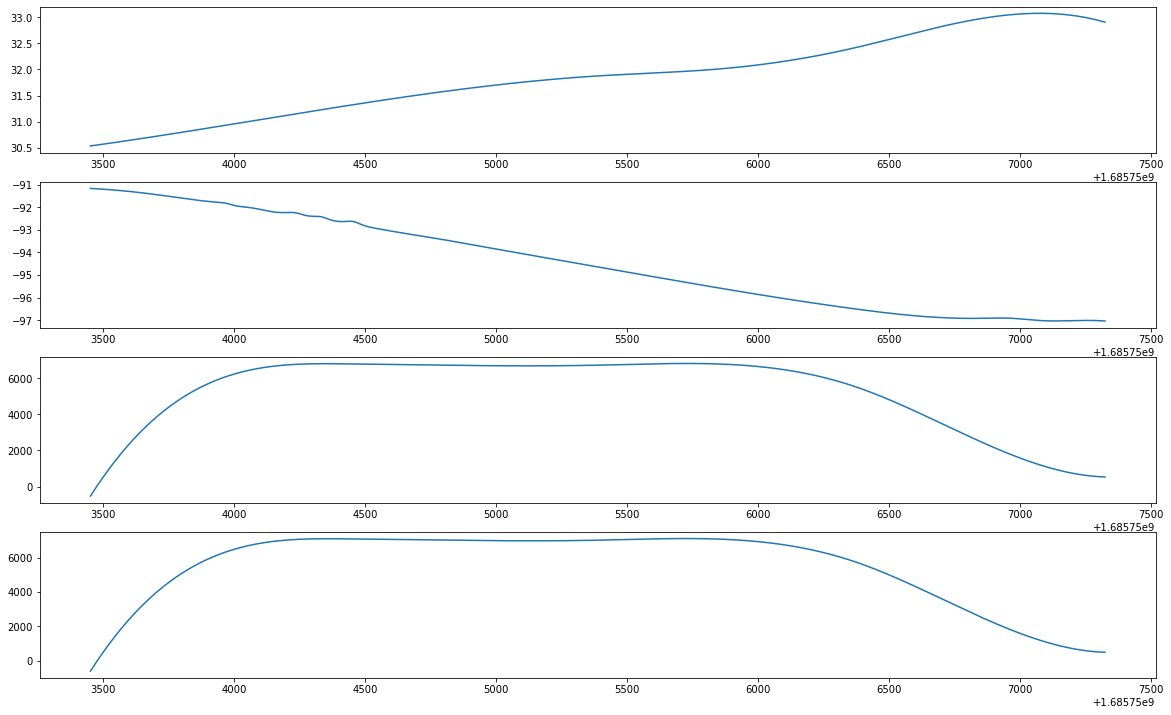

In [430]:
compressor.encode_from_dataframe_to_file(results_vectors, 'time', columns, metadata = {'flight_id':flight['flight_id']})



In [416]:
compressor.compute_compression_factor(results_vectors['time'].values, results_vectors[columns].values, md)

124.09746328437917